In [2]:
# Importing the libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
from torchvision import datasets, models, transforms
from torch.optim import lr_scheduler
from PIL import Image
import pandas as pd
import glob
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import time
import copy
from google.colab.patches import cv2_imshow

In [4]:
# Load the dataframe containing bounding box info of all images
df = pd.read_csv("/content/drive/MyDrive/QR/bounding_boxes.csv",index_col=False)
del df[df.columns[0]]

In [5]:
df.head()

,File_name,top,left,height,width
0,1.jpg,56,41,75,50
1,1_crop.jpg,141,162,51,61
2,1_rotate.jpg,138,2,78,68
3,2.jpg,23,84,83,86
4,2_crop.jpg,143,94,70,76


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
# Apply transformations on images
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [15]:
# dic stores the file name to index mappings of dataframe
dic = {}

# iterate over the rows of the dataframe and populate the dictionary
for index, row in df.iterrows():
    dic[row['File_name']] = index


In [17]:

class ObjectDataset(Dataset):
    def __init__(self, image_paths, labels, dic, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        self.dic = dic
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, index):
        image_path = self.image_paths[index]
        df = self.labels
        row = df.loc[dic[image_path.split('/')[-1]]]
        temp = np.array([row['top'],row['left'],row['height'],row['width']]).reshape(4,1)/224
        label = transforms.ToTensor()(temp)
        image = Image.open(image_path).convert('RGB')
        
        if self.transform is not None:
            image = self.transform(image)
        
        return image, label


In [18]:
# data_path contains all the images that are created in QR_data_generation
data_path = "/content/drive/MyDrive/QR/dataset/"
train_image_paths = []

count = 1
for image_path in glob.glob(os.path.join(data_path, "*.jpg")):
  train_image_paths.append(image_path)
  count+=1
  
train_labels = pd.read_csv("/content/drive/MyDrive/QR/bounding_boxes.csv")
del train_labels[train_labels.columns[0]]

In [19]:
train_labels.shape

(14856, 5)

In [20]:
len(train_image_paths)

14856

In [21]:
# set up data loaders for train, val and test

dataset = ObjectDataset(train_image_paths, train_labels,dic, transform=transform)

train_data,val_data,test_data = random_split(dataset,[0.70,0.15,0.15], generator=torch.Generator().manual_seed(42))

dataset_sizes = {"train" : len(train_data),"val" : len(val_data), "test" : len(test_data)}
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=True)

dataloaders = {"train":train_dataloader, "val":val_dataloader, "test":test_dataloader}


In [22]:
dataset_sizes

{'train': 10400, 'val': 2228, 'test': 2228}

In [23]:
img,boxes = next(iter(train_dataloader))

In [24]:
img[0].shape

torch.Size([3, 224, 224])

(224, 224, 3)


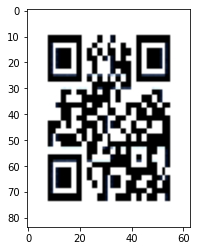

In [25]:
# Visualizing the total image and QR in image
def imshow(inp,top,left = None,height = None,width = None,title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5,0.5,0.5])
    std = np.array([0.5,0.5,0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    print(inp.shape)
    if(top==-1):
      plt.imshow(inp)
    else:
      plt.imshow(inp[top:top+height,left:left+width,:])
#imshow(img[0],-1)
box = (boxes[0].reshape(4,1)*224).int()
imshow(img[0],box[0],box[1],box[2],box[3])

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [27]:
# Calculates the IOU between true_boxes and pred_boxes
def calculate_iou_batch(true_boxes, pred_boxes):
    n_boxes = true_boxes.shape[0]
    iou = torch.zeros((n_boxes,))

    for i in range(n_boxes):
        true_box = true_boxes[i]
        true_box_top_left = true_box[:2]
        true_box_bottom_right = true_box_top_left + true_box[2:]

        pred_box = pred_boxes[i]
        pred_box_top_left = pred_box[:2]
        pred_box_bottom_right = pred_box_top_left + pred_box[2:]

        xA = max(true_box_top_left[1], pred_box_top_left[1])
        yA = max(true_box_top_left[0], pred_box_top_left[0])
        xB = min(true_box_bottom_right[1], pred_box_bottom_right[1])
        yB = min(true_box_bottom_right[0], pred_box_bottom_right[0])

        intersection_area = max(0, xB - xA) * max(0, yB - yA)
        true_box_area = true_box[2] * true_box[3]
        pred_box_area = pred_box[2] * pred_box[3]
        union_area = true_box_area + pred_box_area - intersection_area

        iou[i] = intersection_area / union_area

    return iou.sum()


In [3]:
class ResNet18(torch.nn.Module):
    def __init__(self, num_classes):
        super(ResNet18, self).__init__()
        self.resnet18 = models.resnet18(pretrained=True)
        for param in self.resnet18.parameters():
            param.requires_grad = True
        self.fc1 = nn.Linear(in_features=1000, out_features=4)

    def forward(self, x):
        x = self.resnet18(x)
        x = self.fc1(x)
        return x

In [34]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_IOU = 0.0
    stat_loss = {"train":[],"val":[]}
    stat_IOU = {"train":[],"val":[]}

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            IOU = 0

            # Iterate over data.
            batch = 1
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels.reshape(outputs.shape).float())

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                
                # statistics
                loss = loss.item() * inputs.size(0)
                running_loss += loss
                iou = calculate_iou_batch(labels.reshape(outputs.shape),outputs)
                IOU += iou

                if batch%50==0 and phase == 'train':
                  print(f' Batch: {batch} Loss: {loss:.4f} IOU: {iou/inputs.size(0):.4f}')
                
                batch+=1
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_IOU = IOU.double() / dataset_sizes[phase]
            stat_loss[phase].append(epoch_loss)
            stat_IOU[phase].append(epoch_IOU)
            print(f'{phase} Loss: {epoch_loss:.4f} IOU: {epoch_IOU:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_IOU > best_IOU:
                best_IOU = epoch_IOU
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val IOU: {best_IOU:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model,stat_loss,stat_IOU

In [12]:
# Creating an instance of model
model = ResNet18(num_classes=4)
model = model.to(device)
criterion = nn.MSELoss()

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [37]:
model_best,stat_loss,stat_IOU = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=15)

Epoch 0/14
----------
 Batch: 50 Loss: 2.8749 IOU: 0.0559
 Batch: 100 Loss: 1.0263 IOU: 0.1393
 Batch: 150 Loss: 1.0350 IOU: 0.1432
 Batch: 200 Loss: 0.8148 IOU: 0.1693
 Batch: 250 Loss: 0.8002 IOU: 0.1980
 Batch: 300 Loss: 0.5137 IOU: 0.2690
train Loss: 0.0875 IOU: 0.1578
val Loss: 0.0160 IOU: 0.2680

Epoch 1/14
----------
 Batch: 50 Loss: 0.4283 IOU: 0.2878
 Batch: 100 Loss: 0.4609 IOU: 0.2292
 Batch: 150 Loss: 0.3451 IOU: 0.2962
 Batch: 200 Loss: 0.4093 IOU: 0.2839
 Batch: 250 Loss: 0.3551 IOU: 0.3393
 Batch: 300 Loss: 0.2505 IOU: 0.3296
train Loss: 0.0122 IOU: 0.2968
val Loss: 0.0106 IOU: 0.3198

Epoch 2/14
----------
 Batch: 50 Loss: 0.2261 IOU: 0.4166
 Batch: 100 Loss: 0.3190 IOU: 0.3841
 Batch: 150 Loss: 0.3042 IOU: 0.3966
 Batch: 200 Loss: 0.2913 IOU: 0.3331
 Batch: 250 Loss: 0.2415 IOU: 0.3717
 Batch: 300 Loss: 0.2435 IOU: 0.4138
train Loss: 0.0093 IOU: 0.3424
val Loss: 0.0069 IOU: 0.4097

Epoch 3/14
----------
 Batch: 50 Loss: 0.2256 IOU: 0.4131
 Batch: 100 Loss: 0.2942 IOU: 

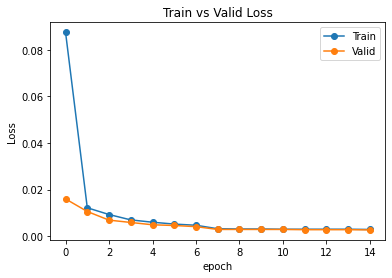

In [14]:
plt.plot(torch.tensor(stat_loss['train']).numpy(),'-o')
plt.plot(torch.tensor(stat_loss['val']).numpy(),'-o')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Loss')
 
plt.show()

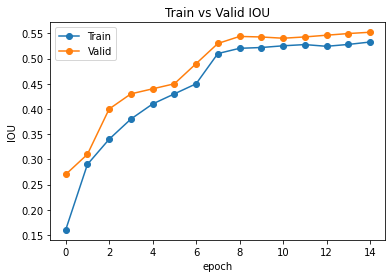

In [16]:
plt.plot(torch.tensor(stat_IOU['train']).numpy(),'-o')
plt.plot(torch.tensor(stat_IOU['val']).numpy(),'-o')
plt.xlabel('epoch')
plt.ylabel('IOU')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid IOU')
 
plt.show()

In [38]:
def test_model(model):
  # set the model to evaluation mode
  model.eval()

  # initialize some variables to keep track of the test results
  total_IOU = 0.0
  total_loss = 0.0
  IOU = 0.0

  # loop through the test data
  with torch.no_grad():
      for data in dataloaders['test']:
          inputs, labels = data
          inputs = inputs.to(device)
          labels = labels.to(device)

          # forward pass through the model
          outputs = model(inputs)

          # calculate the loss and add it to the total loss
          loss = criterion(outputs, labels.reshape(outputs.shape))
          total_loss += loss.item() * inputs.size(0)
          IOU += calculate_iou_batch(labels.reshape(outputs.shape),outputs)
      
          

  # print the test results
  test_loss = total_loss / dataset_sizes['test']
  test_IOU = IOU / dataset_sizes['test']
  print('Test Loss: {:.3f}'.format(test_loss))
  print('Test Accuracy: {:.3f}'.format(test_IOU))

In [41]:
test_model(model_best)

Test Loss: 0.003
Test Accuracy: 0.546


In [10]:
def predict(model,img):
  model.eval()
  x1,y1,h,w = (model(img.unsqueeze(0).to(device)).squeeze(0)*224).int()
  img = img.numpy().transpose((1, 2, 0))
  
  mean = np.array([0.5,0.5,0.5])
  std = np.array([0.5,0.5,0.5])
  img = std * img + mean
  img = (np.clip(img,0,1)*255).astype('uint8').copy()
  print(x1,y1,h,w)
  cv2.rectangle(img, (y1.item(), x1.item()), ((y1+w).item(), (x1+h).item()), (255,0,0), 2)
  plt.imshow(img)

tensor(74, device='cuda:0', dtype=torch.int32) tensor(89, device='cuda:0', dtype=torch.int32) tensor(64, device='cuda:0', dtype=torch.int32) tensor(82, device='cuda:0', dtype=torch.int32)


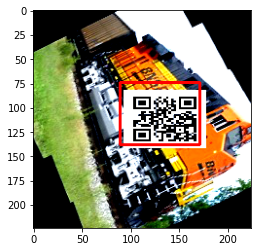

In [11]:
# Testing the model on an input
img = Image.open("/content/drive/MyDrive/QR/dataset/117_rotate.jpg").convert('RGB')
img = transform(img)
predict(model_load,img)

In [40]:
# Save the model
torch.save(model_best.state_dict(), "/content/drive/MyDrive/QR/model_resnet_18_14000.pth")

In [6]:
# Load the model

model_dict = torch.load("/content/drive/MyDrive/QR/model_resnet_18_14000.pth")

# Create a new instance of your PyTorch model
model_load = ResNet18(num_classes=4)
model_load = model_load.to(device)

# Load the saved parameters into the model
model_load.load_state_dict(model_dict)

<All keys matched successfully>